In [1]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import minimize, Bounds

In [2]:
# Функция Растригина
def rastrigin_function(X):

    dim=len(X)         

    OF=0
    for i in range (0,dim):
        OF+=(X[i]**2)-10*math.cos(2*math.pi*X[i])+10

    return OF

In [12]:
from statistics import mean
from statistics import variance

def f1(X):
    res = rastrigin_function(X)
    return res

In [61]:
x0 = [0,1]
bounds=np.array([[-5.12,5.12]]*2)

def callbackF(X):    
    print(X)
    
model = minimize(f1, x0, method='Nelder-Mead', bounds=varbound, callback=callbackF)
print(model.fun)

[0. 1.]
[0. 1.]
[1.40625e-04 9.93750e-01]
[-1.09375e-04  9.93750e-01]
[-1.09375e-04  9.93750e-01]
[1.171875e-05 9.953125e-01]
[1.171875e-05 9.953125e-01]
[1.171875e-05 9.953125e-01]
[-1.12304687e-04  9.94921875e-01]
[-1.12304687e-04  9.94921875e-01]
[-1.12304687e-04  9.94921875e-01]
[1.24511719e-05 9.95019531e-01]
[4.38842773e-05 9.94946289e-01]
[-4.20684814e-05  9.94952393e-01]
0.9949594159327173


 The best solution found:                                                                           
 [0.01457825 0.0005167 ]

 Objective function:
 0.042187008416338045


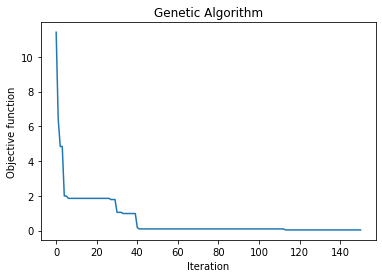

In [52]:
varbound=np.array([[-5.12,5.12]]*2)

algorithm_param = {'max_num_iteration': 150,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

model=ga(function=f1,
         dimension=2,
         variable_type='real',
         variable_boundaries=varbound,
         progress_bar=True, 
         algorithm_parameters=algorithm_param)

model.run()

In [26]:
print("Дисперсия: ", variance(model.report))
print("Математическое ожидание: ", mean(model.report))

Дисперсия:  0.15838954965090904
Математическое ожидание:  0.14700203042689547


 The best solution found:                                                                           
 [0.00461837 0.03088269 0.00053592]

 Objective function:
 0.036036978809083076


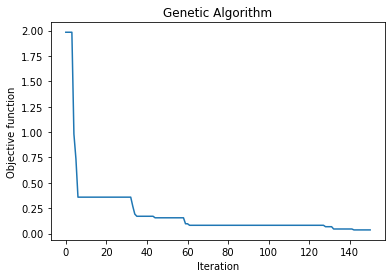

In [47]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return np.sum(X)

varbound=np.array([[0,10]]*3)

algorithm_param = {'max_num_iteration': 150,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

model=ga(function=f,dimension=3,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

model.run()

In [43]:
model.report

[5.52698453285942,
 5.52698453285942,
 3.2611406190722327,
 3.2611406190722327,
 2.707782400071083,
 2.707782400071083,
 2.707782400071083,
 1.6942957001830994,
 1.6942957001830994,
 1.6942957001830994,
 1.6271886305903605,
 1.6271886305903605,
 1.6271886305903605,
 1.6271886305903605,
 1.6271886305903605,
 1.5859257090786105,
 1.5859257090786105,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.8060677709099762,
 0.7404978888073366,
 0.7404978888073366,
 0.5159055732567974,
 0.5084034067485343,
 0.5084034067485343,
 0.5084034067485343,
 0.5084034067485343,
 0.5084034067485343,
 0.5084034067485343,
 0.5084034067485343,
 0.5084034067485343,
 0.42730830299205413,
 0.39386272654326926,
 0.39386272654326926,
 0.39386272654326926,
 0.39386272654326926,
 0.39386272654326926,
 0.39386272654326926,
 0.3938627265